# Inference InternVL3_5-8B

### Load Model

In [1]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText

# Use the -HF version
MODEL_ID = "OpenGVLab/InternVL3_5-8B-HF"

# 1. Load the Model
# For InternVL-HF, we use AutoModelForImageTextToText
model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID, 
    torch_dtype=torch.bfloat16, 
    device_map="auto",
    trust_remote_code=True,      # Still required for custom architectures
    attn_implementation="eager"
).eval()

# 2. Load the Processor
# The processor handles image resizing and tiling automatically
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)

/users/eleves-a/2025/youssef.sidhom/Object_detection_in_documents/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Fetching 4 files:   0%|          | 0/4 [01:39<?, ?it/s]


OSError: [Errno 122] Disk quota exceeded

### Methods for manipulation

Tool for inference zero_shot

In [3]:
def zero_shot_inference(model, processor, image, prompt):
    # 1. Standard Chat Template
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    
    # Preparation for inference
    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    # 2. Processing (InternVL-HF processor handles tiling automatically)
    inputs = processor(
        text=[text],
        images=[image], # Expects a list of PIL images
        padding=True,
        return_tensors="pt",
    ).to(model.device, torch.bfloat16)

    # 3. Inference
    generated_ids = model.generate(
        **inputs, 
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.7
    )
    
    # 4. Trim and Decode
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = processor.batch_decode(
        generated_ids_trimmed, 
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=False
    )[0]

    # 5. Extracting Input Resolution
    # InternVL-HF stores the tiled image dimensions differently than Qwen.
    # pixel_values shape is usually [batch, num_tiles, channels, height, width]
    # where height and width are 448.
    
    # We retrieve the number of patches from the attention mask or pixel values
    # but the easiest way is to look at the 'image_flags' or the aspect ratio logic
    # InternVL-HF standard patch size is 448.
    
    # To get the canvas dimensions the model 'saw':
    # This logic assumes single image batching
    num_tiles = inputs['pixel_values'].shape[0] 
    
    # Note: For grounding, you usually use the ORIGINAL image size 
    # to map the 0-1000 coordinates. But if you need the canvas size:
    canvas_height = 448  # Default base
    canvas_width = 448   # Default base
    
    # If the processor used dynamic tiling, the image is stretched across a grid.
    # For most grounding tasks, original_height/width are the vital stats.
    orig_width, orig_height = image.size

    return output_text, orig_height, orig_width

For visualization purposes

In [4]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
def plot_bounding_boxes(image, bbox_data, height, width,Ground_T):
  image = image.resize((width, height))
  # Parse the JSON input
  # Plot the image
  fig, ax = plt.subplots(1)
  ax.imshow(image)
  ax.axis('off')
  # Plot the bounding boxes and labels
  for item in bbox_data:
      bbox = item['bbox_2d']
      label = item['label']
      rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none',label='Prediction')
      ax.add_patch(rect)
      plt.text(bbox[0], bbox[1] - 10, label, color='r', fontsize=10)
  for item in Ground_T:
    rect = patches.Rectangle((item[0], item[1]), item[2] - item[0], item[3] - item[1], linewidth=2, edgecolor='g', facecolor='none',label='Ground Truth')
    ax.add_patch(rect)
  plt.legend(loc='upper right')
  plt.show()

### Metrics used to evalute performance
- Hard evaluation metrics: 
    - IoU: The standard academic benchmark.
- Soft evaluation metrics:
    - Iop: Intersection over prediction, how much of your predicted box is inside the ground Truth
    - Center-point hit: if the center of the predicted box is inside the center 
    - Center distance error: The distance between the center of the predicted box and the center of the ground truth

In [5]:
import math

def evaluate_detection(pred_box, gt_box, img_width=1, img_height=1):
    """
    Evaluates prediction against ground truth with distance metrics.
    
    Args:
        pred_box (list): [xmin, ymin, xmax, ymax]
        gt_box (list):   [xmin, ymin, xmax, ymax]
        img_width (int): Width of the image (for normalization)
        img_height (int): Height of the image (for normalization)
        
    Returns:
        dict: IoU, IoP, Center Distance (Pixels), Normalized Center Distance (0-1)
    """
    # --- 1. IoU Calculation (Standard) ---
    xA = max(pred_box[0], gt_box[0])
    yA = max(pred_box[1], gt_box[1])
    xB = min(pred_box[2], gt_box[2])
    yB = min(pred_box[3], gt_box[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    predArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gtArea = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    iou = interArea / float(predArea + gtArea - interArea + 1e-6)
    iop = interArea / float(predArea + 1e-6) # Intersection over Prediction

    # --- 2. Center Point Calculation ---
    pred_cx = (pred_box[0] + pred_box[2]) / 2.0
    pred_cy = (pred_box[1] + pred_box[3]) / 2.0
    
    gt_cx = (gt_box[0] + gt_box[2]) / 2.0
    gt_cy = (gt_box[1] + gt_box[3]) / 2.0
    
    # --- 3. Euclidean Distance (Pixels) ---
    # Pythagorean theorem: a^2 + b^2 = c^2
    dist_pixels = math.sqrt((pred_cx - gt_cx)**2 + (pred_cy - gt_cy)**2)
    
    # --- 4. Normalized Distance (0.0 to 1.0) ---
    # Distance relative to the image diagonal. 
    # 0.05 means the center is off by 5% of the image size.
    # This helps compare errors across images of different resolutions.
    img_diagonal = math.sqrt(img_width**2 + img_height**2) + 1e-6
    norm_dist = dist_pixels / img_diagonal

    return {
        "iou": round(iou, 4),
        "iop": round(iop, 4),
        "center_dist_px": round(dist_pixels, 1),
        "norm_center_dist": round(norm_dist, 4)
    }

### Load test images and ground_truth

In [6]:
import json

test_json_path = 'data/test.jsonl'
test_json = []

with open(test_json_path, 'r', encoding='utf-8') as f:
    for line in f:
        data=json.loads(line)
        image_path = 'data/'+data['image']
        groundTruth = json.loads(data['label'])
        test_json.append({
                        'image_path': image_path,
                        'groundTruth': groundTruth
                        })

# Now test_json is a list of dictionaries
print(test_json)

[{'image_path': 'data/images/test_image_152_png_jpg.rf.6336141e7564a9d7e3317f18684228bc_orig.jpg', 'groundTruth': [{'bbox_2d': [251, 504, 417, 547], 'label': 'signatures'}]}, {'image_path': 'data/images/test_qat01f00_jpg.rf.bd6d72fb9d15b1a50aa13dc6c3ae4d92_orig.jpg', 'groundTruth': [{'bbox_2d': [346, 333, 516, 384], 'label': 'signatures'}]}, {'image_path': 'data/images/test_jrk44a00_jpg.rf.49bde548064ee43a487d2f10ce48ff62_orig.jpg', 'groundTruth': [{'bbox_2d': [286, 511, 542, 558], 'label': 'signatures'}]}, {'image_path': 'data/images/test_pvx38c00-page06_6_jpg.rf.c1a201f59050a76046fbf08d79c1d068_orig.jpg', 'groundTruth': [{'bbox_2d': [125, 426, 299, 469], 'label': 'signatures'}, {'bbox_2d': [377, 335, 528, 361], 'label': 'signatures'}]}, {'image_path': 'data/images/test_image_22_png_jpg.rf.08f434b8c2b4f2036d491633b08c205c_orig.jpg', 'groundTruth': [{'bbox_2d': [141, 515, 205, 543], 'label': 'signatures'}, {'bbox_2d': [158, 542, 255, 570], 'label': 'signatures'}, {'bbox_2d': [464, 564,

In [7]:
def parse_ground_truth(Ground_T):
    """
    Extracts GT boxes from Qwen format: <box>(y1,x1),(y2,x2)</box>
    Returns list of [x1, y1, x2, y2] on 0-1000 scale.
    """
    bboxes = []
    for item in Ground_T:
        label = item['label']
        bbox = item['bbox_2d']
        bboxes.append(bbox)
    return bboxes

In [26]:
import json

def parse_and_scale_boxes(output_text, img_width, img_height):
    """
    Parses Qwen2.5-VL output (0-1000 scale) and converts to absolute pixels.
    
    Args:
        output_text (str): The raw string output from the model.
        img_width (int): Original width of the image.
        img_height (int): Original height of the image.
        
    Returns:
        list: A list of dicts with scaled 'bbox_2d' [x1, y1, x2, y2] in pixels.
    """
    try:
        # 1. Clean the output string to get pure JSON
        # This handles cases where the model wraps code in ```json ... ```
        if "```json" in output_text:
            json_str = output_text.split("```json")[1].split("```")[0].strip()
        elif "```" in output_text:
            json_str = output_text.split("```")[1].split("```")[0].strip()
        else:
            json_str = output_text.strip()
            
        # 2. Parse JSON
        data = json.loads(json_str)
        
        # 3. Scale Coordinates
        scaled_results = []
        for item in data:
            if "bbox_2d" in item:
                # Get the normalized 0-1000 coordinates
                # Format is [xmin, ymin, xmax, ymax]
                norm_box = item["bbox_2d"]
                
                # Apply the scaling formula
                abs_box = [
                    (norm_box[0] / 1000.0) * img_width,   # xmin
                    (norm_box[1] / 1000.0) * img_height,  # ymin
                    (norm_box[2] / 1000.0) * img_width,   # xmax
                    (norm_box[3] / 1000.0) * img_height   # ymax
                ]
                
                # Create a new item with the scaled box
                new_item = item.copy()
                new_item["bbox_2d"] = [int(x) for x in abs_box] # Optional: Convert to int for cleaner pixels
                scaled_results.append(new_item)
                
        return scaled_results

    except (json.JSONDecodeError, IndexError, KeyError) as e:
        print(f"Parsing Error: {e}")
        # Return empty list on failure so the pipeline doesn't crash
        return []


In [9]:
import numpy as np

def calculate_iou(boxA, boxB):
    # Standard IoU calculation
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Matches predictions to ground truths using greedy IoU strategy.
    
    Args:
        pred_boxes (list): List of [xmin, ymin, xmax, ymax]
        gt_boxes (list):   List of [xmin, ymin, xmax, ymax]
        iou_threshold (float): Minimum IoU to consider a match valid
        
    Returns:
        matches (list): List of dicts {'pred': box, 'gt': box, 'iou': float}
        unmatched_preds (list): List of pred_boxes that matched nothing
        unmatched_gts (list): List of gt_boxes that were missed
    """
    matches = []
    # pred_boxes = [box['bbox_2d'] for box in pred_boxes]
    
    # Keep track of which indices have been matched
    matched_pred_indices = set()
    matched_gt_indices = set()
    
    # 1. Calculate IoU for ALL pairs
    # Format: (iou, pred_index, gt_index)
    all_pairs = []
    for i, p_box in enumerate(pred_boxes):
        for j, g_box in enumerate(gt_boxes):
            iou = calculate_iou(p_box, g_box)
            if iou > 0.0: # Only consider pairs that overlap at least a little
                all_pairs.append((iou, i, j))
    
    # 2. Sort pairs by IoU (Highest first)
    all_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # 3. Greedy Matching
    for iou, p_idx, g_idx in all_pairs:
        if p_idx not in matched_pred_indices and g_idx not in matched_gt_indices:
            # Found the best remaining match!
            if iou >= iou_threshold:
                matches.append({
                    'pred': pred_boxes[p_idx],
                    'gt': gt_boxes[g_idx],
                    'iou': iou
                })
                matched_pred_indices.add(p_idx)
                matched_gt_indices.add(g_idx)
    
    # 4. Gather leftovers
    unmatched_preds = [p for i, p in enumerate(pred_boxes) if i not in matched_pred_indices]
    unmatched_gts = [g for i, g in enumerate(gt_boxes) if i not in matched_gt_indices]
    
    return matches, unmatched_preds, unmatched_gts

### Running the inference test on single image

In [13]:
prompt='''
Detect all signatures and return their locations and labels in the form of coordinates.
example output format:
```json
[
	{"bbox_2d": [0, 194, 103, 315], "label": "signature"}
]
```
'''


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Predicted Bounding Boxes: [[249, 540, 389, 576]]
False Positives (Hallucinations): 1
Missed Signatures: 1


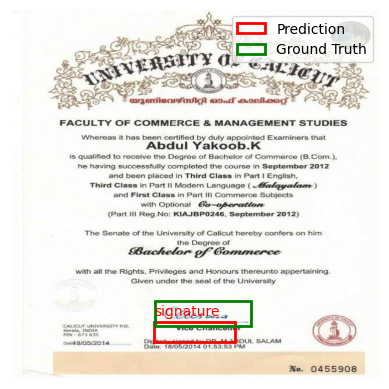

In [27]:
from PIL import Image
for item in test_json:
    image_path = item['image_path']
    Ground_T = parse_ground_truth(item['groundTruth'])
    image = Image.open(image_path).convert('RGB')
    output_text, height, width = zero_shot_inference(model, processor, image, prompt)
    height, width = int(height), int(width)
    #print(f"Output Text: {output_text}")
    #parsing of output
    bbox_data_predict =parse_and_scale_boxes(output_text, image.width, image.height)
    pred_boxes = [x['bbox_2d'] for x in bbox_data_predict if 'bbox_2d' in x]
    print(f"Predicted Bounding Boxes: {pred_boxes}")
    matches, false_positives, misses = match_predictions_to_ground_truth(pred_boxes, Ground_T, iou_threshold=0.1)
    for match in matches:
        # Use your detailed metric function here
        metrics = evaluate_detection(match['pred'], match['gt'], img_width=width, img_height=height)
        
        # Store these specific metrics
        # e.g., results.append(metrics)
        print(f"Matched with IoU: {metrics['iou']}, IoP: {metrics['iop']}, Center Dist: {metrics['center_dist_px']}px, Normalized Dist: {metrics['norm_center_dist']}")

    print(f"False Positives (Hallucinations): {len(false_positives)}")
    print(f"Missed Signatures: {len(misses)}")   
    plot_bounding_boxes(image, bbox_data_predict, image.height, image.width, Ground_T)
    
    break #single image

### Running the inference test images

In [28]:
import numpy as np
import json
from PIL import Image
from tqdm import tqdm

# --- 1. Initialize Accumulators ---
metrics_summary = {
    "iou": [],
    "iop": [],
    "norm_dist": [],
    "false_positives": 0,
    "missed_signatures": 0,
    "total_images": 0
}

prompt = "Detect all signatures and return their locations and labels in the form of coordinates. "

print(f">> Starting evaluation on {len(test_json)} images...")

# --- 2. Main Loop ---
for item in tqdm(test_json):
    image_path = item['image_path']
    
    # Load GT and Image
    try:
        Ground_T = parse_ground_truth(item['groundTruth']) # Ensure this returns list of [x1, y1, x2, y2]
        image = Image.open(image_path).convert('RGB')
        metrics_summary["total_images"] += 1
    except Exception as e:
        print(f"Skipping {image_path}: {e}")
        continue

    # Inference
    try:
        output_text, height, width = zero_shot_inference(model, processor, image, prompt)
                    
        bbox_data_predict = parse_and_scale_boxes(output_text, image.width, image.height)

        
        # Extract just the boxes for matching [x1, y1, x2, y2]
        # Assuming bbox_data_predict is list of dicts: [{'bbox_2d': [...], ...}]
        pred_boxes = [x['bbox_2d'] for x in bbox_data_predict if 'bbox_2d' in x]

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        pred_boxes = []

    # Match Predictions to Ground Truth
    matches, false_positives, misses = match_predictions_to_ground_truth(pred_boxes, Ground_T, iou_threshold=0.1)
    
    # Update Totals for FP / FN
    metrics_summary["false_positives"] += len(false_positives)
    metrics_summary["missed_signatures"] += len(misses)

    # Collect Metrics for Matches
    for match in matches:
        # Evaluate using the normalized distance metric
        m = evaluate_detection(match['pred'], match['gt'], img_width=width, img_height=height)
        
        metrics_summary["iou"].append(m['iou'])
        metrics_summary["iop"].append(m['iop'])
        metrics_summary["norm_dist"].append(m['norm_center_dist'])

# --- 3. Calculate Averages ---
total_matches = len(metrics_summary["iou"])

if total_matches > 0:
    avg_iou = sum(metrics_summary["iou"]) / total_matches
    avg_iop = sum(metrics_summary["iop"]) / total_matches
    avg_norm_dist = sum(metrics_summary["norm_dist"]) / total_matches
else:
    avg_iou = avg_iop = avg_norm_dist = 0.0

# --- 4. Final Report ---
print("\n" + "="*50)
print(f" FINAL EVALUATION REPORT ({metrics_summary['total_images']} Images)")
print("="*50)
print(f"Total Matches Found:      {total_matches}")
print(f"Total Missed Signatures:  {metrics_summary['missed_signatures']}")
print(f"Total False Positives:    {metrics_summary['false_positives']}")
print("-" * 50)
print(f"Mean IoU (Overlap):             {avg_iou:.4f}")
print(f"Mean IoP (Tightness/Precision): {avg_iop:.4f}")
print(f"Mean Normalized Center Error:   {avg_norm_dist:.4f} ({(avg_norm_dist*100):.2f}% of image diagonal)")
print("="*50)

>> Starting evaluation on 257 images...


  0%|          | 1/257 [00:08<37:47,  8.86s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  1%|          | 2/257 [00:13<26:20,  6.20s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  1%|          | 3/257 [00:18<24:47,  5.85s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  2%|▏         | 4/257 [00:23<22:43,  5.39s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  2%|▏         | 5/257 [00:26<19:29,  4.64s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  2%|▏         | 6/257 [00:28<15:40,  3.75s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  3%|▎         | 7/257 [00:40<26:52,  6.45s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  3%|▎         | 8/257 [00:43<22:15,  5.36s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  4%|▎         | 9/257 [00:45<17:13,  4.17s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  4%|▍         | 10/257 [00:48<15:45,  3.83s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  4%|▍         | 11/257 [00:54<18:23,  4.49s/it]Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Parsing Error: Expecting value: line 1 column 1 (char 0)


  4%|▍         | 11/257 [00:55<20:52,  5.09s/it]


KeyboardInterrupt: 